In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model


In [2]:
def load_and_match_images_and_masks(image_folder, mask_folder):
    """
    Loads images and masks from specified folders and matches them based on their filenames.
    This version filters the image folder to include only common image file types.

    Args:
        image_folder (str): The path to the folder containing input images.
        mask_folder (str): The path to the folder containing corresponding masks.

    Returns:
        dict: A dictionary where keys are filenames (without extensions) and values
              are tuples containing (loaded_image, loaded_mask).
              If a mask is not found for an image, or vice versa, that item
              will not be included in the dictionary.
    """
    matched_data = {}

    # Define common image extensions (you can add more if needed)
    image_extensions = ('.png', '.jpg', '.jpeg')

    # List all image files in the image folder, filtering by extension
    image_files = {}
    for f in os.listdir(image_folder):
        file_path = os.path.join(image_folder, f)
        if os.path.isfile(file_path) and f.lower().endswith(image_extensions):
            file_name_without_ext = os.path.splitext(f)[0]
            image_files[file_name_without_ext] = file_path

    # List all files in the mask folder (assuming masks are typically images)
    mask_files = {}
    for f in os.listdir(mask_folder):
        file_path = os.path.join(mask_folder, f)
        if os.path.isfile(file_path) and f.lower().endswith(image_extensions): # Also filter masks for image types
            file_name_without_ext = os.path.splitext(f)[0]
            mask_files[file_name_without_ext] = file_path


    # Match images and masks based on filename
    for name, image_path in image_files.items():
        if name in mask_files:
            mask_path = mask_files[name]
            
            # Read the image and mask
            img = cv2.imread(image_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # Masks are typically single-channel

            # Check if images were successfully read
            if img is not None and mask is not None:
                matched_data[name] = (img, mask)
            else:
                if img is None:
                    print(f"Warning: Could not read image {image_path}. It might be corrupted or an unsupported format.")
                if mask is None:
                    print(f"Warning: Could not read mask {mask_path}. It might be corrupted or an unsupported format.")
        else:
            print(f"Warning: No mask found for image {image_path}.")

    # Check for masks that don't have a corresponding image
    for name, mask_path in mask_files.items():
        if name not in image_files:
            print(f"Warning: No image found for mask {mask_path}.")

    return matched_data

In [3]:


# Specify the paths for image and mask folders
image_folder_path = "./LeatherFinal"
mask_folder_path = "./LeatherFinal_Mask"

IMG_RESIZE_VALUE = 512  #512

threshold_value = 127  # We can adjust this value (IT FOR MASK) --> Binarization

# Call the function to load and match
matched_data = load_and_match_images_and_masks(image_folder_path, mask_folder_path)
Images = []
Masks = []
# Display the loaded information
if matched_data:
    print("\nMatched images and masks:")
    for name, (img, mask) in matched_data.items():
        # print(f"  Filename: {name}")
        Images.append(cv2.resize(img, (IMG_RESIZE_VALUE,IMG_RESIZE_VALUE)))

        MSK_RESZ = cv2.resize(mask,  (IMG_RESIZE_VALUE,IMG_RESIZE_VALUE))
        _, binary_image = cv2.threshold(MSK_RESZ, threshold_value, 255, cv2.THRESH_BINARY) 
        # print(np.unique(binary_image))
        Masks.append(binary_image)
        # print(f"    Image dimensions: {img.shape}")
        # print(f"    Mask dimensions: {mask.shape}")

else:
        print("\nNo matching images and masks found.")





Matched images and masks:


In [4]:
Images_ok = np.array(Images)
Masks_ok = np.array(Masks)

Images_ok = Images_ok / 255.0
Masks_ok = Masks_ok / 255.0  # if binary (0 or 1)

In [5]:
np.unique(Masks_ok)

array([0., 1.])

In [6]:
print(f"Original Images_ok shape: {Images_ok.shape}")
print(f"Original Masks_ok shape: {Masks_ok.shape}")

# --- 1. Data Splitting ---
# 20% for testing, 80% for training + validation
X_train_val, X_test, y_train_val, y_test = train_test_split(
    Images_ok, Masks_ok, test_size=0.20, random_state=42
)

Original Images_ok shape: (133, 512, 512, 3)
Original Masks_ok shape: (133, 512, 512)


In [7]:
# Roughly 80% of X_train_val for training, 20% of X_train_val for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.20, random_state=42 # 0.20 of the remaining 80%
)

In [8]:
print(f"\nTrain set size: {len(X_train)} samples")
print(f"Validation set size: {len(X_val)} samples")
print(f"Test set size: {len(X_test)} samples")

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")



Train set size: 84 samples
Validation set size: 22 samples
Test set size: 27 samples
X_train shape: (84, 512, 512, 3)
y_train shape: (84, 512, 512)
X_val shape: (22, 512, 512, 3)
y_val shape: (22, 512, 512)
X_test shape: (27, 512, 512, 3)
y_test shape: (27, 512, 512)


In [9]:
# #  U-Net Model Definition 
# def conv_block(input_tensor, num_filters):
#     x = layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input_tensor)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     return x

# def build_unet_model(input_shape=(512, 512, 3), num_classes=1): # num_classes=1 for binary segmentation
#     inputs = layers.Input(input_shape)

#     # Encoder (Downsampling Path)
#     conv1 = conv_block(inputs, 64)
#     pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
#     # pool1 = layers.Dropout(0.1)(pool1) # Optional: Add dropout

#     conv2 = conv_block(pool1, 128)
#     pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
#     # pool2 = layers.Dropout(0.1)(pool2)

#     conv3 = conv_block(pool2, 256)
#     pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
#     # pool3 = layers.Dropout(0.2)(pool3)

#     conv4 = conv_block(pool3, 512)
#     pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
#     # pool4 = layers.Dropout(0.2)(pool4)

#     # Bottleneck
#     conv5 = conv_block(pool4, 1024)
#     # conv5 = layers.Dropout(0.3)(conv5) # Optional: Add dropout

#     # Decoder (Upsampling Path)
#     up6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
#     # Concatenate with skip connection from conv4. Ensure dimensions match
#     up6 = layers.concatenate([up6, conv4], axis=-1)
#     up6 = conv_block(up6, 512)

#     up7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(up6)
#     up7 = layers.concatenate([up7, conv3], axis=-1)
#     up7 = conv_block(up7, 256)

#     up8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(up7)
#     up8 = layers.concatenate([up8, conv2], axis=-1)
#     up8 = conv_block(up8, 128)

#     up9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(up8)
#     up9 = layers.concatenate([up9, conv1], axis=-1)
#     up9 = conv_block(up9, 64)

#     # Output Layer
#     # For binary segmentation, use 'sigmoid' and 1 filter
#     # For multi-class segmentation, use 'softmax' and num_classes filters
#     if num_classes == 1:
#         outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(up9)
#     else:
#         outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(up9)

#     model = models.Model(inputs=[inputs], outputs=[outputs])
#     return model


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

def conv_block(input_tensor, num_filters):
    """
    A block of two convolutional layers with Batch Normalization and ReLU activation.
    """
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = layers.BatchNormalization()(x)
    return x

def attention_block(input_skip, input_decoder, num_filters):
    """
    Attention Gate Block.
    It takes the skip connection and the decoder output as input
    and generates a weighted output for the concatenation.
    """
    # Gating signal from the decoder path
    g = layers.Conv2D(num_filters, (1, 1), padding='same')(input_decoder)
    
    # Skip signal from the encoder path
    x = layers.Conv2D(num_filters, (1, 1), padding='same')(input_skip)
    
    # Add them and apply ReLU activation
    add_relu = layers.Activation('relu')(layers.Add()([g, x]))
    
    # Generate attention weights (sigmoid activation)
    psi = layers.Conv2D(1, (1, 1), padding='same')(add_relu)
    attention_weights = layers.Activation('sigmoid')(psi)
    
    # Resample attention weights to match skip connection size if necessary
    # Assuming same size after convolutions, no upsampling is needed here
    
    # Apply attention weights to the skip connection
    attention_output = layers.Multiply()([input_skip, attention_weights])
    
    return attention_output

def build_attention_unet_model(input_shape=(512, 512, 3), num_classes=1):
    """
    Builds a more powerful Attention U-Net model.
    The depth of the model is increased to 5 levels (from 4).
    Dropout and Attention Gates are added.
    """
    inputs = layers.Input(input_shape)

    # Encoder (Downsampling Path)
    conv1 = conv_block(inputs, 64)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = layers.Dropout(0.1)(pool1)

    conv2 = conv_block(pool1, 128)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = layers.Dropout(0.1)(pool2)

    conv3 = conv_block(pool2, 256)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = layers.Dropout(0.2)(pool3)

    conv4 = conv_block(pool3, 512)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = layers.Dropout(0.2)(pool4)
    
    # Bottleneck (increased filters)
    conv5 = conv_block(pool4, 1024)
    conv5 = layers.Dropout(0.3)(conv5)

    # Decoder (Upsampling Path)
    # Up-sampling with Attention Block 1
    up6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    att_conv4 = attention_block(conv4, up6, 512) # Apply attention
    up6 = layers.concatenate([up6, att_conv4], axis=-1)
    up6 = conv_block(up6, 512)

    # Up-sampling with Attention Block 2
    up7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(up6)
    att_conv3 = attention_block(conv3, up7, 256) # Apply attention
    up7 = layers.concatenate([up7, att_conv3], axis=-1)
    up7 = conv_block(up7, 256)

    # Up-sampling with Attention Block 3
    up8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(up7)
    att_conv2 = attention_block(conv2, up8, 128) # Apply attention
    up8 = layers.concatenate([up8, att_conv2], axis=-1)
    up8 = conv_block(up8, 128)

    # Up-sampling with Attention Block 4
    up9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(up8)
    att_conv1 = attention_block(conv1, up9, 64) # Apply attention
    up9 = layers.concatenate([up9, att_conv1], axis=-1)
    up9 = conv_block(up9, 64)

    # Output Layer
    if num_classes == 1:
        outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(up9)
    else:
        outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(up9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# --- نحوه استفاده ---
# برای ایجاد مدل، می‌توانید به صورت زیر عمل کنید:
# attention_unet = build_attention_unet_model(input_shape=(512, 512, 3), num_classes=1)
# attention_unet.summary()

In [11]:
# Evaluation Metrics for Segmentation
# IoU (Intersection over Union) or Jaccard Index is standard
# Dice Coefficient is also very common (often preferred for imbalanced classes)

# Custom IoU metric (MeanIoU is also built-in in Keras)
def iou_metric(y_true, y_pred):
    # Threshold predicted masks to get binary output
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + 1e-15) / (union + 1e-15) # Add epsilon to avoid division by zero
    return iou

# Dice Coefficient
def dice_coef(y_true, y_pred, smooth=1e-15):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


In [12]:
# Instantiate the U-Net model
image_height = IMG_RESIZE_VALUE # Assuming these are defined as in your context
image_width = IMG_RESIZE_VALUE
input_shapes = (image_height, image_width, 3)
model = build_attention_unet_model(input_shape = input_shapes, num_classes=1)
# model.summary()

plot_file_name = 'attention_unet_model_architecture.png'

print(f"\nAttempting to plot the model and save to {plot_file_name}...")

plot_model(model,
               to_file=plot_file_name,
               show_shapes=True,      # Show input/output shapes of layers
               show_layer_names=True, # Show layer names
               rankdir='TB',          # 'TB' for Top-Bottom, 'LR' for Left-Right
               expand_nested=False    # Set to True to expand nested models (if any)
              )
print(f"Model plot saved successfully to {plot_file_name}")


Attempting to plot the model and save to attention_unet_model_architecture.png...
Model plot saved successfully to attention_unet_model_architecture.png


In [13]:
len(np.unique(Masks_ok))

2

In [14]:
np.unique(Masks_ok[0])

array([0., 1.])

In [15]:
# --- 3. Compile the Model with Metrics ---

# For binary segmentation (your case with num_classes=1), use BinaryCrossentropy
# For multi-class segmentation, use CategoricalCrossentropy or SparseCategoricalCrossentropy
if len(np.unique(Masks_ok)) <= 2: # Check if masks are binary (0 and 1)
    loss_function = tf.keras.losses.BinaryCrossentropy()
    output_activation = 'sigmoid'
else:
    loss_function = tf.keras.losses.SparseCategoricalCrossentropy() # or CategoricalCrossentropy if one-hot encoded
    output_activation = 'softmax'


In [16]:
# Use Adam optimizer
optimizer = optimizers.Adam(learning_rate=1e-4) # Start with a small learning rate

model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=[iou_metric, dice_coef, 'accuracy']) # Accuracy can sometimes be misleading for imbalanced masks


In [17]:
# --- 4. Model Training (Example) ---

# Callbacks for better training management
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=250, monitor='val_loss', restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('attention_unet_best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
]

# For demonstration, let's just train for a few epochs with dummy data
history = model.fit(
    X_train, y_train,
    epochs=300, # Reduced for quick demonstration
    batch_size=2, # 2 Adjust for real data and GPU
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)
print("--- Model Training Finished ---")

Epoch 1/300
42/42 [==============================] - 63s 510ms/step - loss: 0.7501 - iou_metric: 0.0228 - dice_coef: 0.0392 - accuracy: 0.5692 - val_loss: 0.5817 - val_iou_metric: 0.0175 - val_dice_coef: 0.0305 - val_accuracy: 0.9402
Epoch 2/300
42/42 [==============================] - 20s 480ms/step - loss: 0.6117 - iou_metric: 0.0436 - dice_coef: 0.0477 - accuracy: 0.7452 - val_loss: 0.8675 - val_iou_metric: 0.0174 - val_dice_coef: 0.0348 - val_accuracy: 0.2213
Epoch 3/300
42/42 [==============================] - 20s 480ms/step - loss: 0.5375 - iou_metric: 0.1078 - dice_coef: 0.0510 - accuracy: 0.8856 - val_loss: 2.1230 - val_iou_metric: 0.0168 - val_dice_coef: 0.0292 - val_accuracy: 0.1429
Epoch 4/300
42/42 [==============================] - 20s 486ms/step - loss: 0.4881 - iou_metric: 0.2474 - dice_coef: 0.0569 - accuracy: 0.9575 - val_loss: 0.9398 - val_iou_metric: 0.0134 - val_dice_coef: 0.0299 - val_accuracy: 0.2955
Epoch 5/300
42/42 [==============================] - 22s 515ms/s


--- Evaluating on Test Set ---
7/7 [==============================] - 14s 1s/step - loss: 0.0664 - iou_metric: 0.4647 - dice_coef: 0.5838 - accuracy: 0.9875

Test Set Evaluation Results:
  loss: 0.0664
  iou_metric: 0.4647
  dice_coef: 0.5838
  accuracy: 0.9875

--- Training History Visualization ---


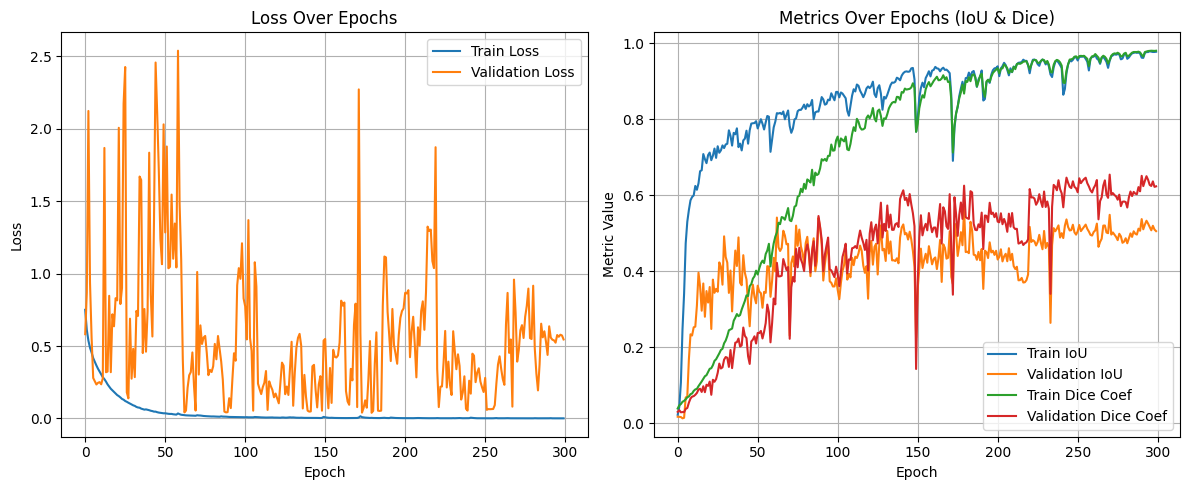

In [18]:
# --- 5. Evaluation Metrics for Test Set ---
print("\n--- Evaluating on Test Set ---")
test_results = model.evaluate(X_test, y_test, batch_size =4, verbose=1)

# Map the results to metric names
metric_names = model.metrics_names
test_metrics = dict(zip(metric_names, test_results))

print("\nTest Set Evaluation Results:")
for name, value in test_metrics.items():
    print(f"  {name}: {value:.4f}")

# --- 6. Visualization of Training History ---
print("\n--- Training History Visualization ---")
if history:
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot IoU and Dice Coeff
    plt.subplot(1, 2, 2)
    plt.plot(history.history['iou_metric'], label='Train IoU')
    plt.plot(history.history['val_iou_metric'], label='Validation IoU')
    plt.plot(history.history['dice_coef'], label='Train Dice Coef')
    plt.plot(history.history['val_dice_coef'], label='Validation Dice Coef')
    plt.title('Metrics Over Epochs (IoU & Dice)')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# The path to your saved model file.
model_path = 'attention_unet_best_model.keras'

# --- Step 1: Load the model ---
try:
    # Use load_model to load the saved Keras model.
    model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully!")
    
    # Optionally, print the model summary to verify.
    # loaded_model.summary()
    
except Exception as e:
    print(f"Error loading the model: {e}")

Error loading the model: Unknown metric function: iou_metric. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.



--- Visualizing Test Set Predictions ---
1/1 [==============================] - 1s 574ms/step


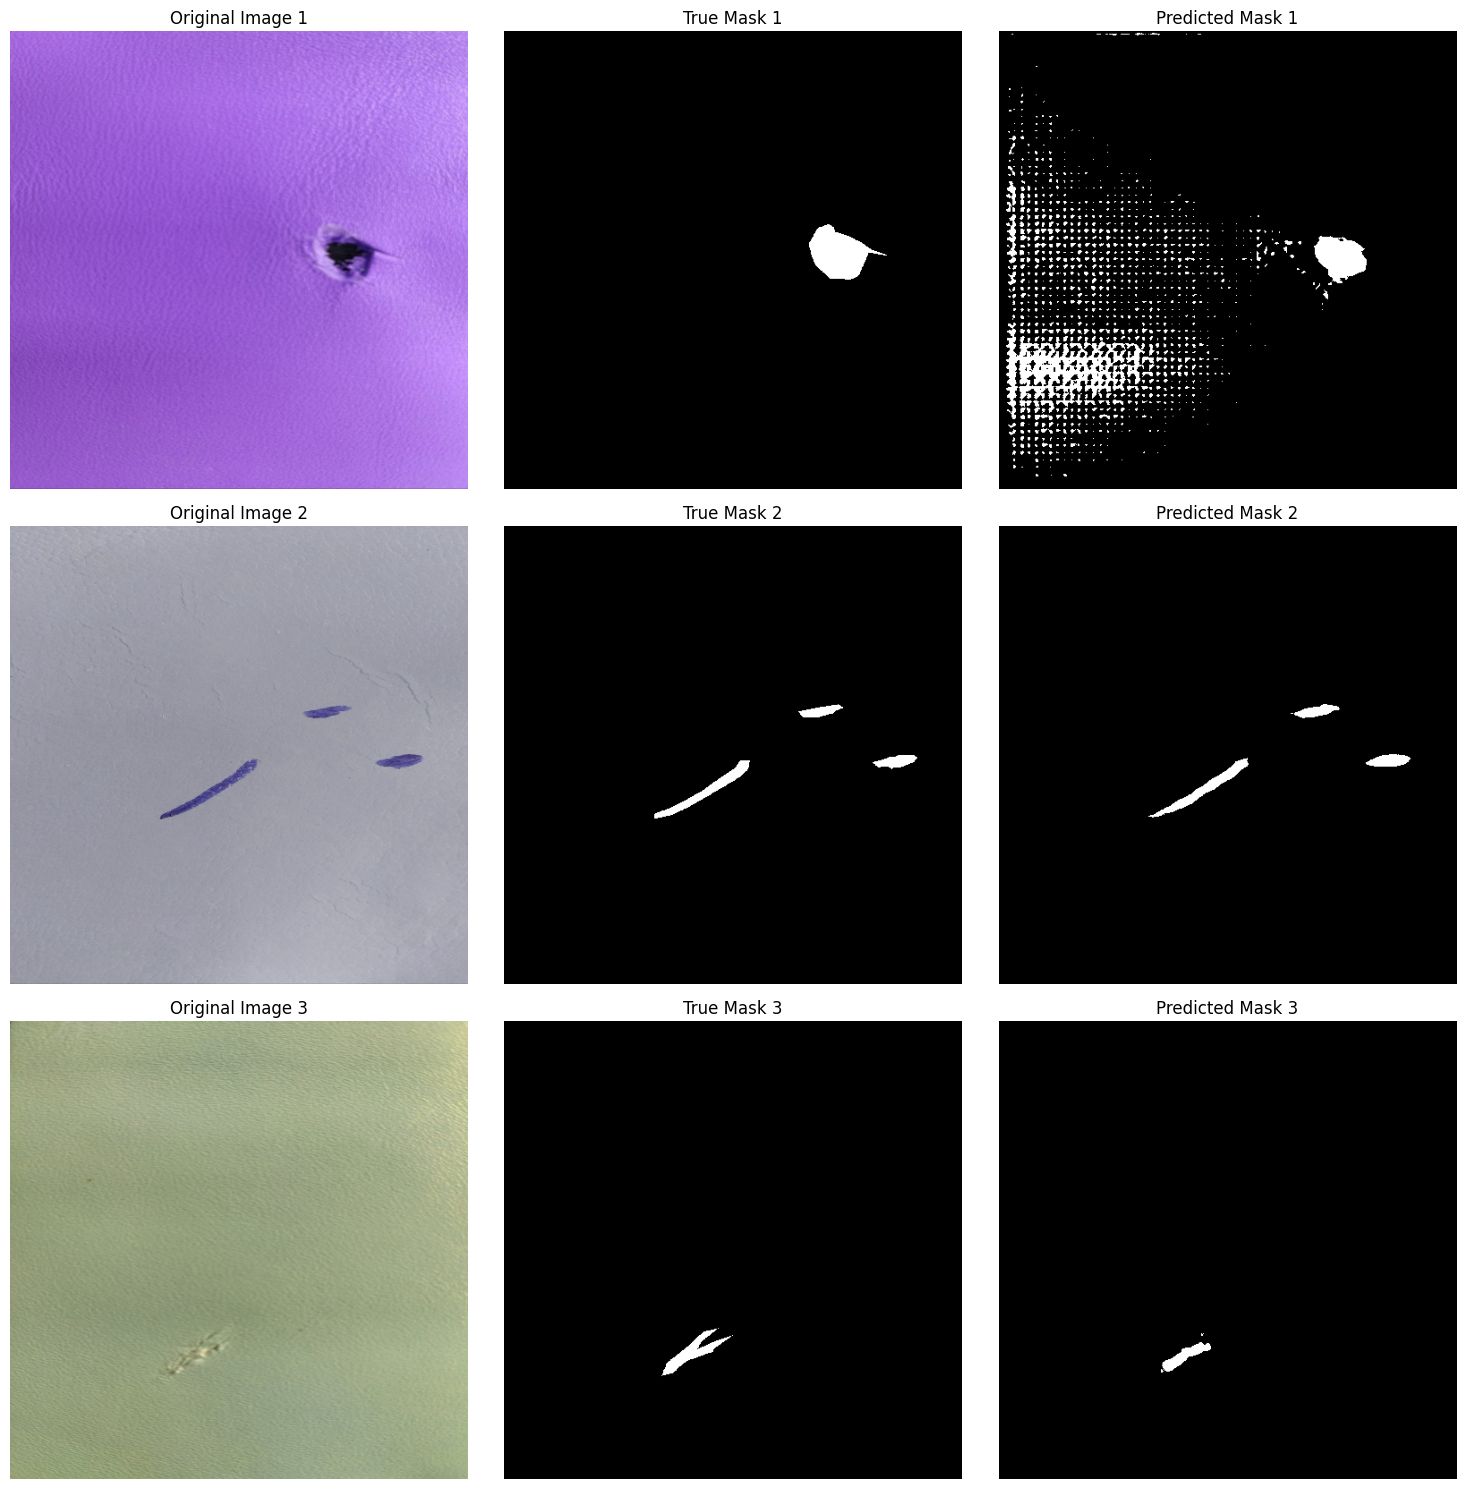

: 

In [ ]:
# --- Optional: Visualize some predictions from the test set ---
print("\n--- Visualizing Test Set Predictions ---")
num_visualizations = 3 # Number of test samples to visualize

# Get predictions
test_predictions = model.predict(X_test[:num_visualizations])

plt.figure(figsize=(15, 5 * num_visualizations))
for i in range(num_visualizations):
    # Original Image
    plt.subplot(num_visualizations, 3, i * 3 + 1)
    plt.imshow(X_test[i])
    plt.title(f'Original Image {i+1}')
    plt.axis('off')

    # True Mask
    plt.subplot(num_visualizations, 3, i * 3 + 2)
    plt.imshow(y_test[i], cmap='gray')
    plt.title(f'True Mask {i+1}')
    plt.axis('off')

    # Predicted Mask (thresholded)
    plt.subplot(num_visualizations, 3, i * 3 + 3)
    # For binary masks, threshold at 0.5
    predicted_mask = (test_predictions[i] > 0.5).astype(np.float32).squeeze()
    plt.imshow(predicted_mask, cmap='gray')
    plt.title(f'Predicted Mask {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()
